In [213]:
import tensorflow
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from pycocotools.coco import COCO
import random
from camera_utils import fix_barrel_distortion
import math

Load Model

In [214]:
from tensorflow.keras.models import load_model
model_path = "C:/Users/chuck/OneDrive/Desktop/Honors/models/resnet_backbone_512.hdf5"
model = load_model(model_path, compile=False)
model.compile()

Load an image

In [215]:
def random_image(folders):
    files = []
    for folder in folders:
        for dirpath, dirnames, filenames in os.walk(folder):
            for filename in filenames:
                files.append(os.path.join(dirpath, filename))
    if not files:
        return None
    else:
        return cv2.imread(random.choice(files))

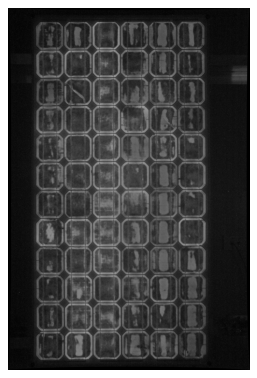

In [245]:
folders = ["C:/Users/chuck/OneDrive/Desktop/Honors/M0060/M0060",
           "C:/Users/chuck/OneDrive/Desktop/Honors/BT1/BT1"]
image = random_image(folders)

toml_path = "C:/Users/chuck/OneDrive/Desktop/Honors/solarEL/solarel/configs/camera_config.toml"
image = fix_barrel_distortion(image, toml_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.fastNlMeansDenoising(image, None, 15, 7, 21)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image)

Crop to PV module

In [246]:
def make_image_square(image):
    height, width, _ = image.shape
    if height == width:
        return image  # Already square
    elif height > width:
        new_width = height
        new_image = np.zeros((new_width, new_width, 3), np.uint8)
        offset = (new_width - width) // 2
        new_image[:, offset:offset+width, :] = image
    else:
        new_height = width
        new_image = np.zeros((new_height, new_height, 3), np.uint8)
        offset = (new_height - height) // 2
        new_image[offset:offset+height, :, :] = image
    return new_image

4272 4272


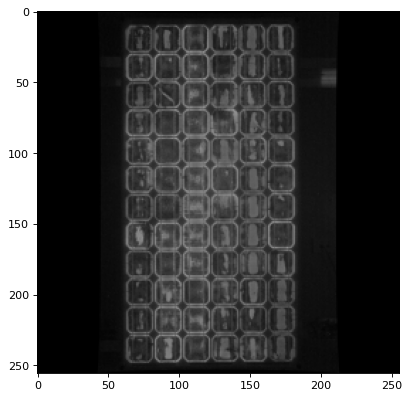

In [247]:
image_square = make_image_square(image)
image_square_og = np.copy(image_square)
og_width, og_height, _ = np.shape(image_square)
image_square = cv2.resize(image_square, (256, 256), interpolation=cv2.INTER_AREA)
# image_square = cv2.cvtColor(image_square, cv2.COLOR_BGR2GRAY)
# _, image_square = cv2.threshold(image_square, 10, 255, cv2.THRESH_TOZERO)
# image_square = cv2.cvtColor(image_square, cv2.COLOR_GRAY2RGB)
print(og_height, og_height)

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(image_square)

In [248]:
model_path_module = "C:/Users/chuck/OneDrive/Desktop/Honors/models/resnet_PV_module_256.hdf5"
model_module = load_model(model_path_module, compile=False)
model_module.compile()

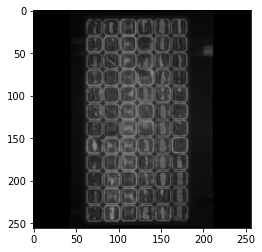

In [249]:
image_square_cp = np.copy(image_square)
image_square = np.expand_dims(image_square, 0)
plt.imshow(image_square[0])

1/1 [==============================] - 1s 919ms/step
(256, 256)


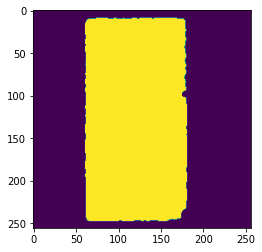

In [250]:
prediction = (model_module.predict(image_square))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]*255
predicted_img = predicted_img.astype(np.uint8)
print(np.shape(predicted_img))
plt.imshow(predicted_img)

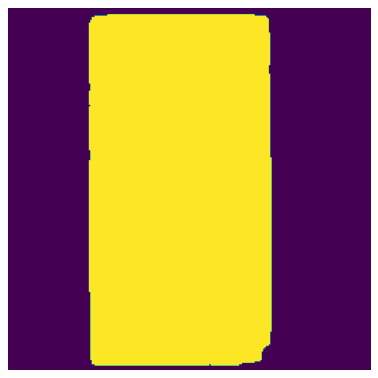

In [251]:
kernel = np.ones((10,10), np.uint8)
dilated = cv2.dilate(predicted_img, kernel, iterations=1)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(dilated)

1


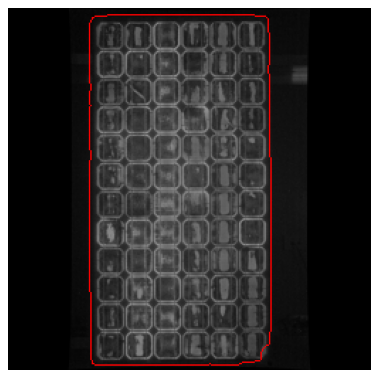

In [252]:
contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
image_cp = np.copy(predicted_img)
image_cp = cv2.drawContours(image_square_cp, contours, -1, (255,0,0), 1)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image_cp)

In [257]:

def largest_convex_hull_rect(contours):
    c = max(contours, key = cv2.contourArea)
    # Compute the convex hull of the contour
    hull = cv2.convexHull(c)
    # Compute the minimum bounding rectangle of the convex hull
    rect = cv2.minAreaRect(hull)
    # Convert the rectangle coordinates to integers and return them
    return cv2.boxPoints(rect).astype(np.float32)


def order_points(points):
    # Compute the sums and differences of the x and y coordinates
    sums = [p[0] + p[1] for p in points]
    diffs = [p[0] - p[1] for p in points]
    # Find the indices of the points with the smallest and largest sums
    topleft_index = np.argmin(sums)
    bottomright_index = np.argmax(sums)
    # Find the indices of the points with the smallest and largest differences
    topright_index = np.argmin(diffs)
    bottomleft_index = np.argmax(diffs)
    return np.float32([points[topleft_index], points[topright_index], points[bottomright_index], points[bottomleft_index]])

rect = largest_convex_hull_rect(contours)
rect = rect.flatten()
rect = rect.reshape((4,2))
rect = order_points(rect)

src_pts = rect.astype(np.float32)

In [258]:
scaled_src_points = []

scale_x = og_width / 256
scale_y = og_height / 256
for point in src_pts:
    x_scaled = int(point[0] * scale_x)
    y_scaled = int(point[1] * scale_y)
    scaled_src_points.append((x_scaled, y_scaled))
scaled_src_points = np.array(scaled_src_points, np.float32) 
x, y, w, h = cv2.boundingRect(scaled_src_points)

In [259]:
print(scaled_src_points)

[[ 951.   83.]
 [ 951. 4205.]
 [3087. 4205.]
 [3087.   83.]]


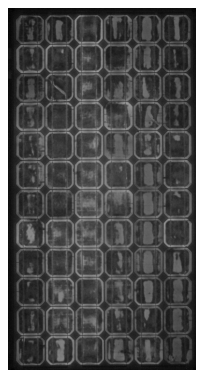

In [260]:
dest_pts = np.array([[0, 0], [0, h], [w, h], [w, 0]], np.float32)
M = cv2.getPerspectiveTransform(scaled_src_points, dest_pts)
# Apply the perspective transform to the image
cropped = cv2.warpPerspective(image_square_og, M, (w, h))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped)

Split image into 512 by 512 images for classification

(512, 200)
(2003, 1152)


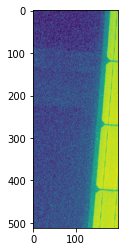

In [205]:
cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
cropped_cp = np.copy(cropped)
cropped_cp = cv2.pyrDown(cropped_cp)
og_height, og_width = np.shape(cropped_cp)
test = cropped_cp[:512, :200]
print(np.shape(test))
print(np.shape(cropped_cp))
plt.imshow(test)


In [206]:
height, width = np.shape(cropped_cp)
print(width/512)
print(height/512)
horz_splits = int(np.ceil(width/512)+1)
vert_splits = int(np.ceil(height/512)+1)
print(vert_splits, horz_splits)

2.25
3.912109375
5 4


In [207]:
import cv2
import numpy as np

def split_row_image(row, split, shape):
    split_images = []
    height, width = np.shape(row["image"])

    first_image = row["image"][:, 0:shape[1]]
    image = {
        "image": first_image,
        "x1": 0,
        "y1":row["y1"]
    }
    split_images.append(image)

    horz_middle_ims_count = split-2
    image_seperation = width//(split+1)
    for i in range(horz_middle_ims_count):
        middle_pixel = image_seperation + (i+1)*image_seperation
        middle_image = row["image"][:, middle_pixel-shape[0]//2:middle_pixel+shape[1]//2]
        image = {
            "image": middle_image,
            "x1": middle_pixel-shape[0]//2,
            "y1":row["y1"]
        }
        split_images.append(image)


    last_image = row["image"][:, width-shape[1]:]
    image = {
        "image": last_image,
        "x1": width-shape[1],
        "y1":row["y1"]
    }
    split_images.append(image)

    return split_images

In [208]:
def split_image_into_rows(image, split, shape):
    column_images = []
    height, _ = np.shape(image)

    first_image = image[0:shape[0], :]
    row = {
        "image": first_image,
        "y1": 0
        }
    column_images.append(row)

    vert_middle_ims_count = split-2
    image_seperation = height//(split+1)
    for i in range(vert_middle_ims_count):
        middle_pixel = image_seperation + (i+1)*image_seperation
        middle_image = image[middle_pixel-shape[0]//2:middle_pixel+shape[1]//2, :]
        row = {
            "image": middle_image,
            "y1": middle_pixel-shape[0]//2
            }
        column_images.append(row)


    last_image = image[height-shape[0]:, :]
    row = {
            "image": last_image,
            "y1": height-shape[0]
            }
    column_images.append(row)

    return column_images

410


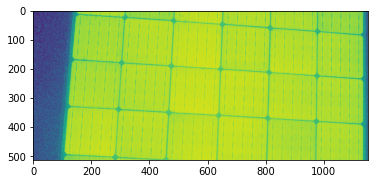

In [209]:
row_images = split_image_into_rows(cropped_cp, vert_splits, (512, 512))
plt.imshow(row_images[1]["image"])
print(row_images[1]["y1"])

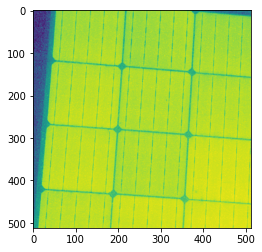

In [210]:
images = []
for row in row_images:
    images.append(split_row_image(row, horz_splits+1, (512, 512)))

temp = images[0][1]["image"]
temp = cv2.merge((temp, temp, temp))
temp = np.expand_dims(temp, 0)
plt.imshow(images[0][1]["image"])

(1, 512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512)


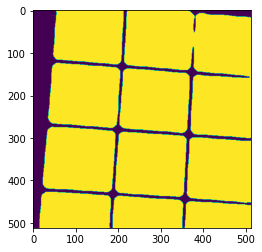

In [211]:
print(np.shape(temp))
prediction = (model.predict(temp))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]*255
print(np.shape(predicted_img))
plt.imshow(predicted_img)

In [212]:
classifications = []
for row in images:
    for image in row:
        temp = image["image"]
        # plt.imshow(temp)
        # plt.show()
        temp = cv2.merge((temp, temp, temp))
        temp = np.expand_dims(temp, 0)
        prediction = (model.predict(temp))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]*255
        predicted_img = predicted_img.astype(np.uint8)
        predicted_img = cv2.erode(predicted_img, (20,20))
        image["image"] = predicted_img
        print(np.shape(predicted_img))
        # plt.imshow(predicted_img)
        # plt.show()


1/1 [==============================] - 0s 398ms/step
(512, 512)
1/1 [==============================] - 0s 359ms/step
(512, 512)
1/1 [==============================] - 0s 360ms/step
(512, 512)
1/1 [==============================] - 0s 360ms/step
(512, 512)
1/1 [==============================] - 0s 357ms/step
(512, 512)
1/1 [==============================] - 0s 364ms/step
(512, 512)
1/1 [==============================] - 0s 368ms/step
(512, 512)
1/1 [==============================] - 0s 374ms/step
(512, 512)
1/1 [==============================] - 0s 352ms/step
(512, 512)
1/1 [==============================] - 0s 352ms/step
(512, 512)
1/1 [==============================] - 0s 369ms/step
(512, 512)
1/1 [==============================] - 0s 405ms/step
(512, 512)
1/1 [==============================] - 0s 367ms/step
(512, 512)
1/1 [==============================] - 0s 380ms/step
(512, 512)
1/1 [==============================] - 0s 356ms/step
(512, 512)
1/1 [==============================] - 0

KeyboardInterrupt: 

In [ ]:
def place_image(large_image, small_image, top_left):
    small_height, small_width = small_image.shape
    
    small_top, small_left = top_left
    
    small_bottom = small_top + small_height
    small_right = small_left + small_width
    
    large_image[small_top:small_bottom, small_left:small_right] = small_image
    
    return large_image

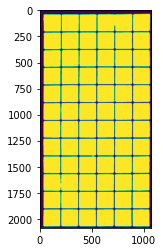

In [ ]:
masks = []
for row in images:
    for image in row:
        temp = image["image"]
        x, y = image["x1"], image["y1"]
        blank = np.zeros((og_height, og_width))
        new = place_image(blank, temp, (y,x))
        masks.append(new)

final_mask = np.zeros((og_height, og_width))
for mask in masks:
    final_mask = cv2.bitwise_or(final_mask, mask)

# final_mask = cv2.pyrDown(final_mask)
plt.imshow(final_mask)

Edge detection / Hough Lines

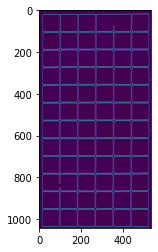

In [ ]:
final_mask_cp = np.copy(final_mask)
final_mask_cp = final_mask_cp.astype(np.uint8)
edges = cv2.Canny(final_mask_cp, 120, 180)
edges = cv2.dilate(edges, (10,10))
edges = cv2.pyrDown(edges)
plt.imshow(edges)

In [ ]:
def horz_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/120, votes)
        votes = int(votes*0.95)
        
    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)<0.1:
            good_lines.append(line)
    return good_lines

def vert_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/120, votes)
        votes = int(votes*0.95)

    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)>50:
            good_lines.append(line)
    return good_lines

def draw_hough_lines(image, hough_lines):
    # Loop over the detected lines
    for line in hough_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 +1200 * (-b))
        y1 = int(y0 + 1200 * (a))
        x2 = int(x0 - 1200 * (-b))
        y2 = int(y0 - 1200 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return image


def merge_similar_hough_lines(lines, rho_threshold, theta_threshold):
    """
    Merges similar Hough lines in OpenCV.
    
    :param lines: list of lines in (rho, theta) format.
    :param threshold_distance: maximum distance between lines to be considered similar.
    :param threshold_angle: maximum angle difference between lines to be considered similar.
    :return: list of merged lines in (rho, theta) format.
    """

     # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    filtered_lines = []

    if filter:
        for i in range(len(lines)): # filtering
            if line_flags[i]:
                filtered_lines.append(lines[i])

    return filtered_lines

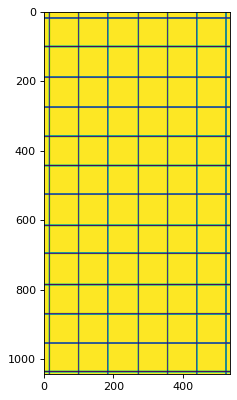

In [ ]:
edges_cp = np.copy(edges)*0

horz_lines = horz_hough_lines(edges, 400, 2)
vert_lines = vert_hough_lines(edges, 600, 2)
lines = horz_lines + vert_lines
lines = merge_similar_hough_lines(lines, 50, 0.5)
lines = merge_similar_hough_lines(lines, 50, 0.5)


cells = draw_hough_lines(edges_cp, lines)
cells = cv2.bitwise_not(cells)
cells = cv2.erode(cells, (5,5))

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(cells)

Cell split

In [ ]:
# def find_similar_contours(example_shape, contours):
#     similar_contours = []
#     for contour in contours:
#         # Approximate the contour with a polygon
#         perimeter = cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
#         similarity = cv2.matchShapes(approx, example_shape, cv2.CONTOURS_MATCH_I1, 0)
#         if similarity < 0.05:
#             similar_contours.append(contour)
#     return similar_contours

cells = cv2.pyrUp(cells)
cells = cv2.pyrUp(cells)

# contours, hierarchy = cv2.findContours(cells, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# panel_shape = np.array([[0,0], [0,1], [1,1], [1,0]])
# panel_contours = find_similar_contours(panel_shape, contours)

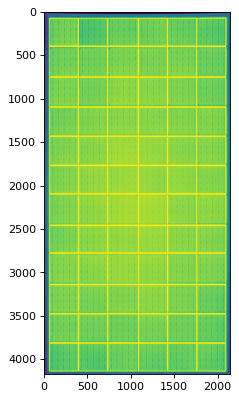

In [ ]:
panel_images = []
panel_contours, _ = cv2.findContours(cells, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
def width_and_height_filter(contours, width, height, tolerance):
    good_contours = []
    for contour in panel_contours:
        _, _, w, h = cv2.boundingRect(contour)
        if w < width*(1-tolerance) or w > width * (1+tolerance):
            continue
        if h < height*(1-tolerance) or w > height * (1+tolerance):
            continue
        good_contours.append(contour)
    return good_contours

panel_contours = width_and_height_filter(panel_contours, 325, 325, 0.2)
cropped_cp = np.copy(cropped)
cropped_cp = cv2.drawContours(cropped_cp, panel_contours, -1, (255,255,255), 10)
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(cropped_cp)

In [ ]:
def label_image(image, text,font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=2, color=(255, 255, 255), thickness=2):
    # Get the dimensions of the image
    height, width = image.shape
    
    # Get the dimensions of the text
    text_width, text_height = cv2.getTextSize(text, font, font_scale, thickness)[0]
    
    # Compute the position of the text
    text_x = int((width - text_width) / 2)
    text_y = int((height + text_height) / 2)
    
    # Put the text on the image
    cv2.putText(image, text, (text_x, text_y), font, font_scale, (0,0,0), thickness+1)
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, thickness)

In [ ]:
def sort_contours(contours):
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        centers.append((cx, cy))
    
    # Sort the contours by their x-coordinate
    sorted_indices = np.argsort([center[1] for center in centers])
    sorted_contours = [contours[i] for i in sorted_indices]

     # Split the contours into rows
    rows = []
    row_indices = []
    prev_center_y = None
    for i, contour in enumerate(sorted_contours):
        center_x, center_y = centers[sorted_indices[i]]
        if prev_center_y is None or center_y - prev_center_y > 10:
            row_indices.append([i])
            rows.append([contour])
        else:
            row_indices[-1].append(i)
            rows[-1].append(contour)
        prev_center_y = center_y
    
    # Sort the contours within each row by their x-coordinate
    for i, row in enumerate(rows):
        row_sorted_indices = np.argsort([centers[sorted_indices[j]][0] for j in row_indices[i]])
        rows[i] = [row[j] for j in row_sorted_indices]

    return rows

rows = sort_contours(panel_contours)

62 82 333 321
398 82 333 321
734 82 349 321
1086 82 333 321
1422 82 333 321
1758 82 333 321
62 410 333 345
398 410 333 345
734 410 349 345
1086 410 333 345
1422 410 333 345
1758 410 333 345
62 762 333 337
398 762 333 337
734 762 349 337
1086 762 333 337
1422 762 333 337
1758 762 333 337
62 1106 333 329
398 1106 333 329
734 1106 349 329
1086 1106 333 329
1422 1106 333 329
1758 1106 333 329
62 1442 333 329
398 1442 333 329
734 1442 349 329
1086 1442 333 329
1422 1442 333 329
1758 1442 333 329
62 1778 333 321
398 1778 333 321
734 1778 349 321
1086 1778 333 321
1422 1778 333 321
1758 1778 333 321
62 2106 333 353
398 2106 333 353
734 2106 349 353
1086 2106 333 353
1422 2106 333 353
1758 2106 333 353
62 2466 333 313
398 2466 333 313
734 2466 349 313
1086 2466 333 313
1422 2466 333 313
1758 2466 333 313
62 2786 333 353
398 2786 333 353
734 2786 349 353
1086 2786 333 353
1422 2786 333 353
1758 2786 333 353
62 3146 333 329
398 3146 333 329
734 3146 349 329
1086 3146 333 329
1422 3146 333 329
17

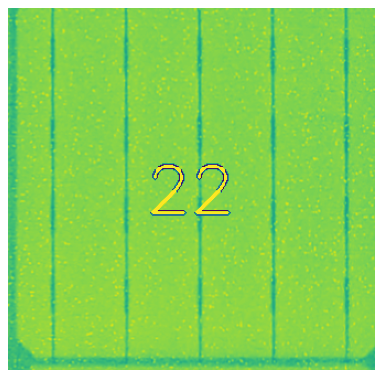

In [ ]:
i = 0
height, width = np.shape(cropped_cp)
panel_image_rows = []
for row in rows:
    panel_image_rows.append([])
    for contour in row:
        x,y,w,h = cv2.boundingRect(contour)
        print(x,y,w,h)
        delta = 0
        panel_image = cropped[max(0, y-delta):min(y+h+delta, height), max(0, x-delta):min(x+w+delta, width)]
        label_image(panel_image, f'{i}')
        panel_images.append(panel_image)
        panel_image_rows[-1].append(panel_image)
        i += 1


example = random.choice(panel_images)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(example)

c:\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


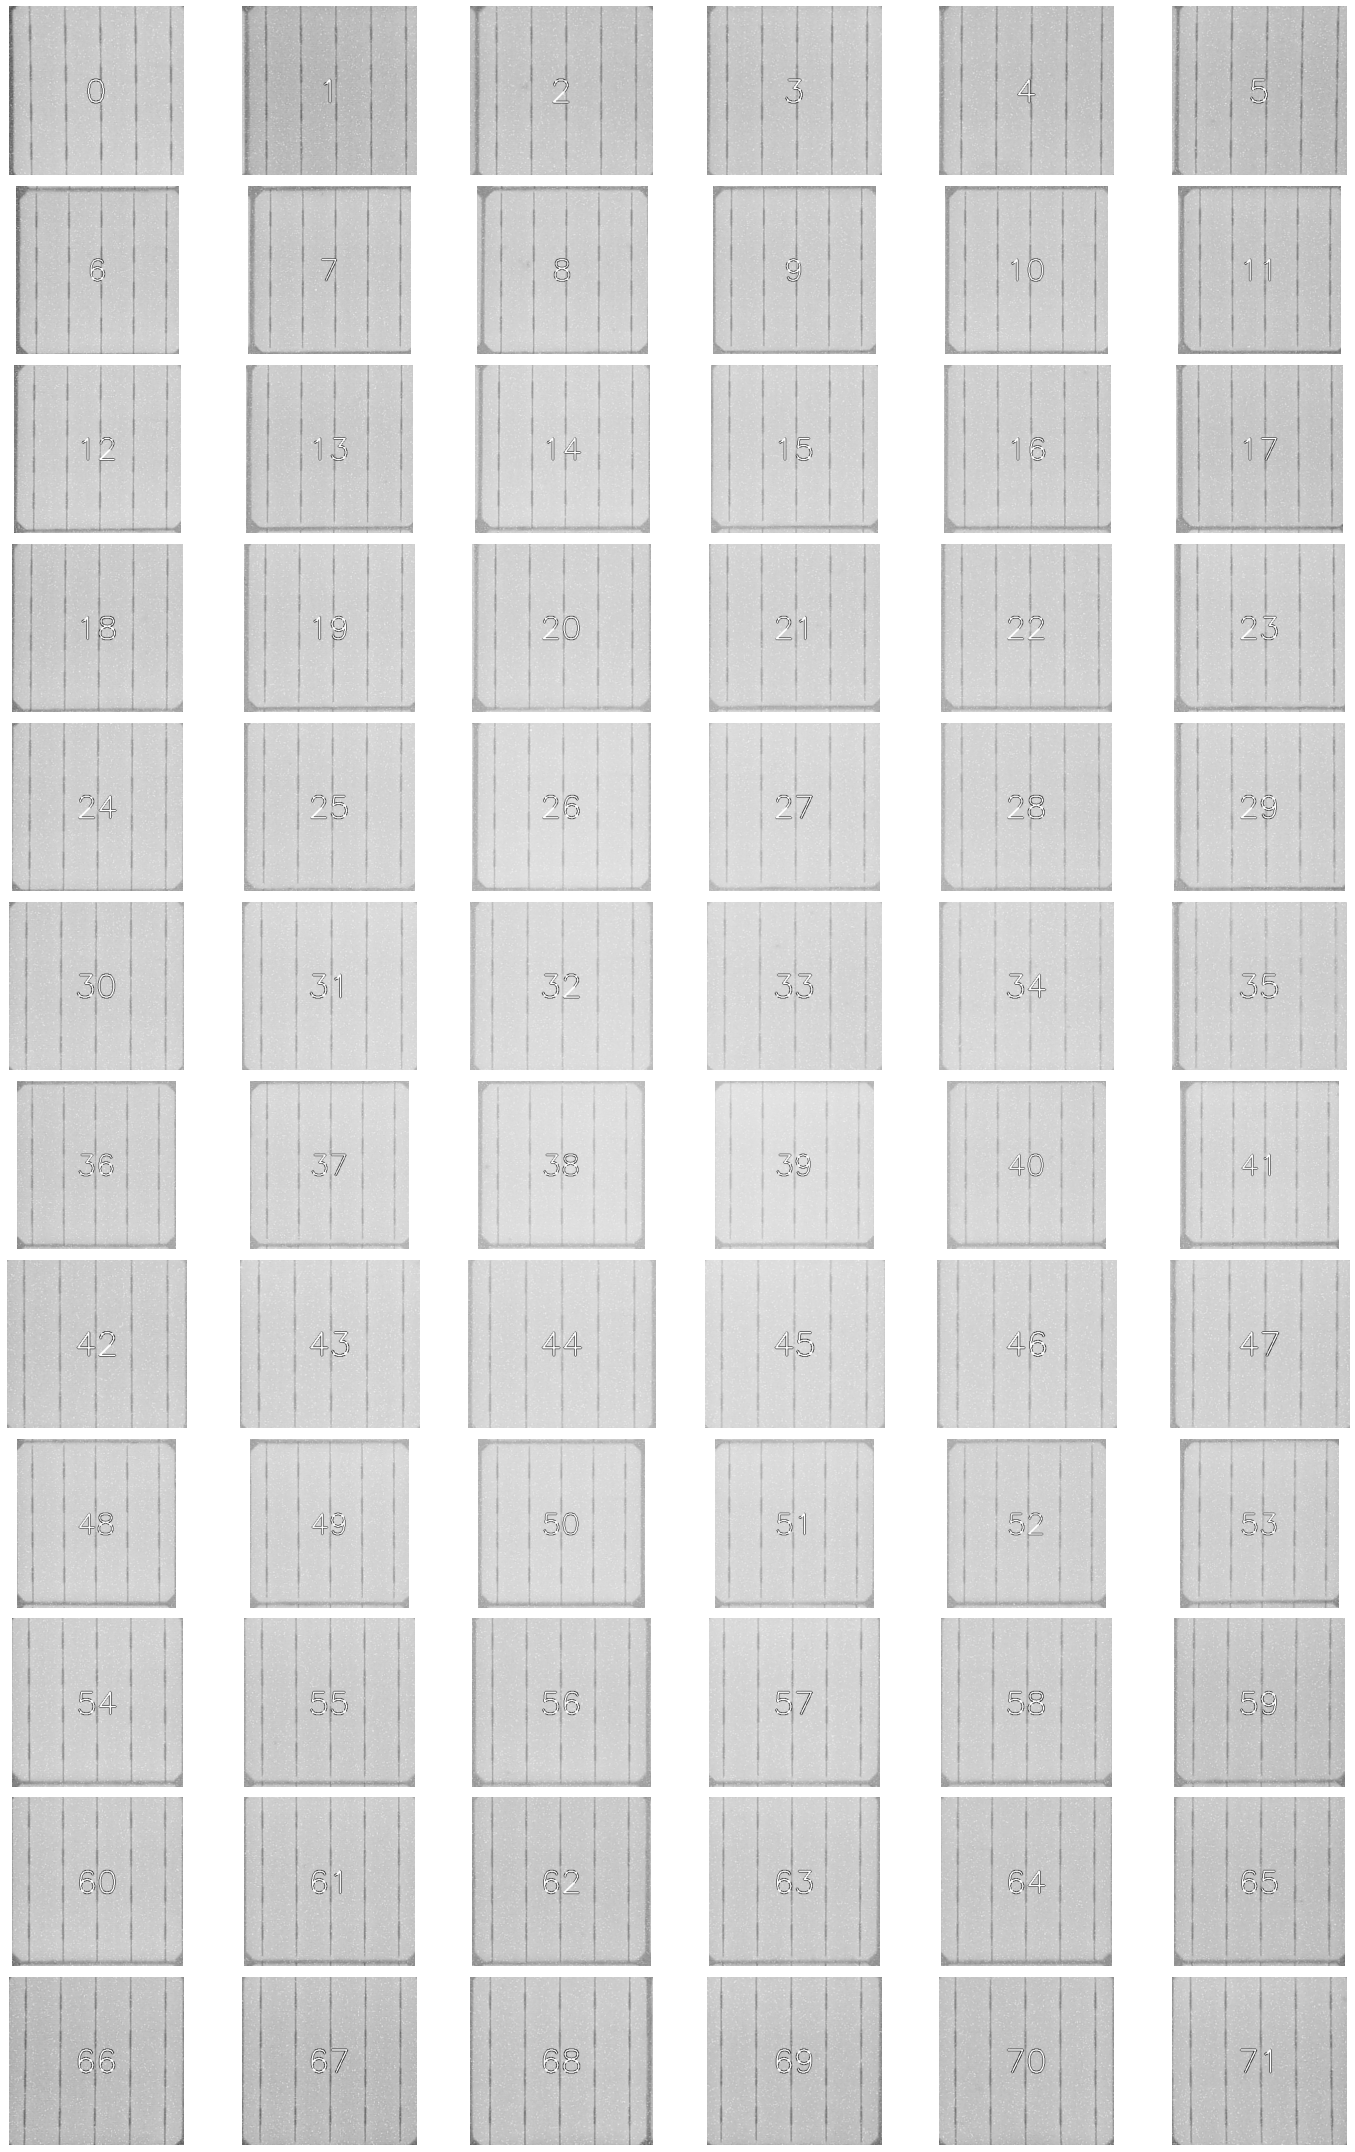

In [ ]:
num_rows, num_cols = np.shape(panel_image_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 30))

for row in range(num_rows):
    for col in range(num_cols):
        # Generate a random image for each subplot
        image = panel_image_rows[row][col]

        # Display the image in the current subplot
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()
# Show the plot
plt.show()

(256, 256, 3)
hello
(256, 3)


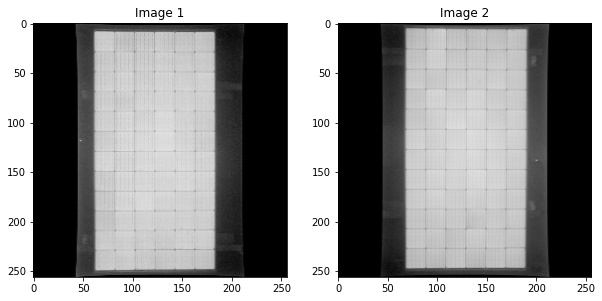

In [ ]:
test = cv2.imread("test.jpg")
print(test.shape)
print("hello")
print(image_square[0].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the first subplot
ax[0].imshow(test)
ax[0].set_title('Image 1')

# Plot the second image on the second subplot
ax[1].imshow(image_square)
ax[1].set_title('Image 2')
plt.show()


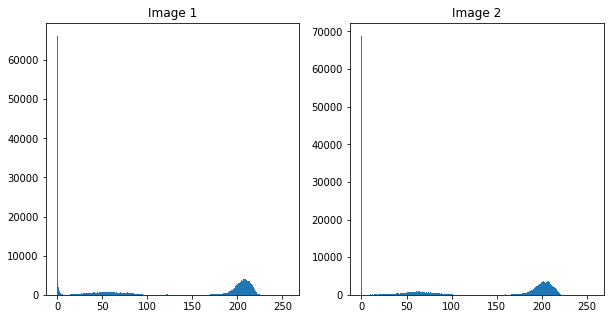

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the first subplot
ax[0].hist(test.ravel(), bins=256, range=(0, 256))
ax[0].set_title('Image 1')

# Plot the second image on the second subplot
ax[1].hist(image_square.ravel(), bins=256, range=(0, 256))
ax[1].set_title('Image 2')
plt.show()